# PCA. Метод Главных Компонент

## Для тех, кто знал, но забыл

### Ковариация, собственные векторы и значения

Среднее арифметическое: $\overline{X} = \frac{1}{n}\sum\limits_{i = 1}^n X_i$

Дисперсия: $\sigma^2 = \mathbf{E}[(X - \mathbf{E}[X])^2]$. Мы будем использовать $\frac{1}{n-1}\sum\limits_{i=1}^n(X_i-\overline{X})^2$

Ковариация: $cov(X, Y) = \mathbf{E}[(X_i - \overline{X})(Y_i - \overline{Y})]$. Для набора признаков $X_i$ ковариационная матрица - матрица $C = [c_{ij}] = [cov(X_i, X_j)]$

Аналогично, у нас будет так называемая выборочная ковариационная матрица 
$[c_{ij}] = \frac{1}{n-1}\sum\limits_{l=1}^n(x_{li} - \overline{X_i})(x_{lj} - \overline{X_j})$

Собственный вектор $x$ для матрицы $A$ с собственным значением $\lambda$: $Ax = \lambda x$

In [1]:
from sklearn.datasets import make_classification
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pylab
import scipy as sp
import numpy as np
import scipy.sparse as sps
import scipy.sparse.linalg as spla
%matplotlib inline

## Метод диагонализации ковариационной матрицы

Генерируем датасет. Нормируем признаки так, чтобы матожидание каждого было равно $0$. Тогда $cov(X_1, X_2) = \mathbf{E}[X_1X_2]$

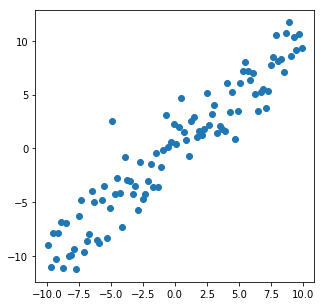

In [2]:
x = np.arange(-10, 10, 0.2)
y = x + np.random.normal(scale=2, size=(100,))
X = np.vstack((x,y))
X[0, :] -= X[0, :].mean()
X[1, :] -= X[1, :].mean()
plt.figure(figsize=(5, 5))
plt.scatter(X[0, :], X[1, :])

### А зачем нам собственные значения и ковариационная матрица?

Ковариационная матрица помогает описать данные - отлично.

Будем проецировать наши данные на какой-нибудь вектор $v$. Проекция должна иметь наибольшую дисперсию среди всех остальных проекций, так как в таком случае она лучше всего сохранит информацию о данных. Запишем это в виде формул.

Проекция данных на вектор $v$: $v^TX = X^*$.

$Var(X^*) = \mathbf{E}[X^* \cdot X^{*T}] = \mathbf{E}[v^TX \cdot (v^TX)^T] = \mathbf{E}[v^TX X^Tv] = v^T\mathbf{E}[XX^T]v = v^TCov(X)v$

В общем, максимум последнего выражения достигается, если $v$ - собственный вектор с максимальным собственным значением матрицы $Cov(X)$.

Аналогично расширяем на большие размерности: для того, чтобы проецировать на некое $m$-мерное пространство данные, нужно выбрать $m$ векторов с максимальными собственными значениями.

Находим ковариационную матрицу и ее собственные векторы и собственные значения.

In [3]:
Cov = np.cov(X)
print('Covariation matrix: \n', Cov)
[eig1, eig2], eig_vectors = np.linalg.eig(Cov)
eig_v_1 = eig_vectors[:, 0]
eig_v_2 = eig_vectors[:, 1]
print('Eigenvalues: \n', [eig1, eig2])
print('Eigenvectors: \n', eig_vectors.T)

Covariation matrix: 
 [[ 33.66666667  33.91071217]
 [ 33.91071217  37.90075651]]
Eigenvalues: 
 [1.8069801472033546, 69.760443028865865]
Eigenvectors: 
 [[-0.72880336  0.68472306]
 [-0.68472306 -0.72880336]]


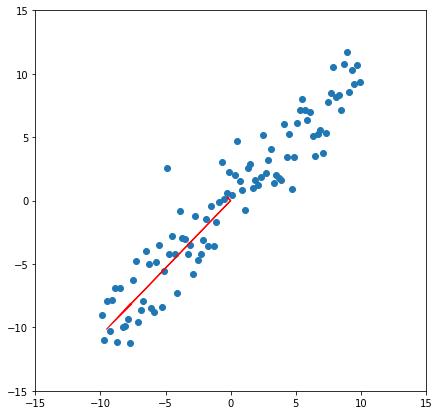

In [4]:
plt.figure(figsize=(7, 7))
plt.xlim((-15, 15))
plt.ylim((-15, 15))
plt.scatter(X[0, :], X[1, :])
arr1 = plt.Arrow(0, 0, eig_v_1[0] * eig1 / 5, eig_v_1[1] * eig1 / 5, color='r', width=0.2) 
arr2 = plt.Arrow(0, 0, eig_v_2[0] * eig2 / 5, eig_v_2[1] * eig2 / 5, color='r', width=0.2)  
plt.gca().add_patch(arr1)
plt.gca().add_patch(arr2)

In [5]:
X_new = np.dot(eig_v_2,X)
for i in range(3):
    X_restored = np.dot(X_new[i],eig_v_2)
    print('Restored: ', X_restored)
    print('Original: ', X[:,i])
    print()

Restored:  [-9.12558463 -9.71306085]
Original:  [-9.9        -8.98548454]

Restored:  [-10.03340367 -10.6793224 ]
Original:  [ -9.7        -10.99256078]

Restored:  [-8.39744681 -8.93804783]
Original:  [-9.5        -7.90218049]



## SVD. Метод для взрослых

### Що це SVD

$\forall X$ ранга $r$ $\exists U, D, V$: $X = UDV^T$, $U, V$ - ортогональные, а $D$ обладает следующими свойствами:
* Вне диагонали все элементы равны 0
* Диагональные элементы положительные и не возрастают
* Ненулевыми являются только первые $r$ элементов

### Посмотрим на PCA по другим углом

Пусть есть матрица признаков $F = [f_{ij}] = [f_j(i)]$ размера $l\times n$. Хотим получить матрицу $G = [g_{ij}] = [g_j(i)]$ размера $l\times m$. Переход будет задаваться матрицей $V$.

Хотим $\hat{F} = GV^T \approx F$, иными словами $||GV^T - F||^2 \rightarrow min$ по $V$ и $G$.

Ну и оказывается, что для $m \leq r$ минимум достигается, когда столбцы матрицы $V$ это собственные векторы матрицы $F^TF$ соответствующие $m$ максимальным собственным значениям, а матрица $G = FV$. При этом:
* $V$ - ортонормирована.
* $G$ - ортогональна: $G^TG = \Lambda = diag(\lambda_1, ..., \lambda_m)$
* $V\Lambda = F^TFV$, $G\Lambda = FF^TG$
* $||GV^T - F||^2 = ||F||^2 - tr\Lambda = \sum\limits_{i=m+1}^n \lambda_i$

Это же сингулярное разложение! Воу! $G = U\sqrt{\Lambda}, F = U\sqrt{\Lambda} V^T$

#### Наглядный пример того, что это работает и зачем оно работает.

In [6]:
X, y = make_classification(500, class_sep=10, random_state=1234)

for i in range(X.shape[1]):
    X[:, i] -= X[:, 0].mean()

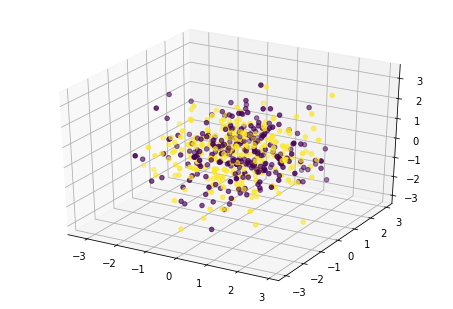

In [7]:
fig = pylab.figure()
ax = Axes3D(fig)
ax.scatter(X[:, 0], X[:, 10], X[:, 19], zdir="z", c=y)

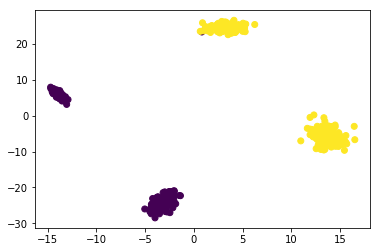

In [8]:
U, s, Vt = spla.svds(X, k=2)

X_hat = U.dot(np.diag(s))

plt.scatter(X_hat[:, 0], X_hat[:, 1], c=y)

#### Image compression

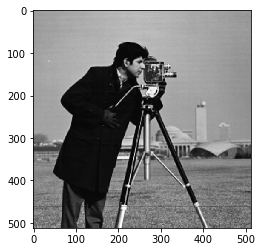

In [9]:
from skimage.data import camera

img = camera()

plt.imshow(img, cmap='gray')

required memory for original image: 262144
required memory for compressed image: 51250


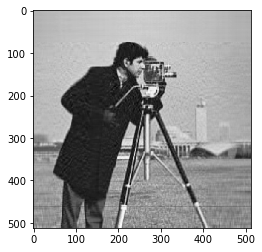

In [10]:
x, y = img.shape
mean = np.mean(img)
img_ = img - mean
U, S, Vt = sp.linalg.svd(img_)

def plot_n_components(i, j):
    u = U[:, i:j].reshape((x, j - i))
    v = Vt[i:j].reshape((j - i, y))
    p = (u * S[0:j - i]).dot(v)
    p = p + mean
    print('required memory for original image: {}'.format(512 * 512))
    print('required memory for compressed image: {}'.format(x * (j - i) + y * (j - i) + (j - i)))
    plt.imshow(p, cmap='Greys_r')
    
plot_n_components(0, 50)

#### Pattern recognition

Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7
Extracting the top 150 eigenfaces from 966 faces
done in 0.390s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.031s
Fitting the classifier to the training set
done in 26.701s
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Predicting people's names on the test set
done in 0.049s
                   precision    recall  f1-score   support

     Ariel Sharon       0.53      0.62      0.57        13
     Colin Powell       0.76      0.85      0.80        60
  Donald Rumsfeld       0.65      0.74      0.69        27
    George W Bush       0.87      0.88      0.88       146
Gerhard Schroeder       0.79      0.60      0.68        25
      Hugo Chavez       0.77      0.67      0.71    

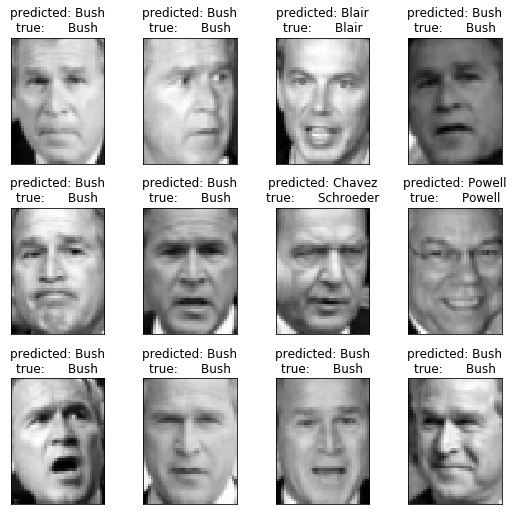

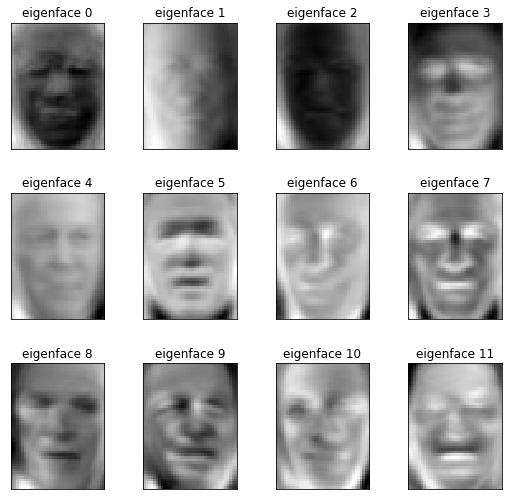

In [11]:
from time import time
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC

lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

n_samples, h, w = lfw_people.images.shape

X = lfw_people.data
n_features = X.shape[1]

y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

n_components = 150

print("Extracting the top %d eigenfaces from %d faces"
      % (n_components, X_train.shape[0]))
t0 = time()
pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(X_train)
print("done in %0.3fs" % (time() - t0))

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("done in %0.3fs" % (time() - t0))

print("Fitting the classifier to the training set")
t0 = time()
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf = clf.fit(X_train_pca, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)

print("Predicting people's names on the test set")
t0 = time()
y_pred = clf.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))

def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

plt.show()